In [1]:
!git clone https://github.com/Sharonnae/FitnessAI.git

Cloning into 'FitnessAI'...
remote: Enumerating objects: 4795, done.
remote: Counting objects: 100% (1200/1200), done.
remote: Compressing objects: 100% (1038/1038), done.
remote: Total 4795 (delta 161), reused 1174 (delta 159), pack-reused 3595
Receiving objects: 100% (4795/4795), 267.80 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (280/280), done.
Updating files: 100% (1912/1912), done.


In [2]:
%cd /content/FitnessAI
!git checkout CNN---Accuracy

/content/FitnessAI
Branch 'CNN---Accuracy' set up to track remote branch 'CNN---Accuracy' from 'origin'.
Switched to a new branch 'CNN---Accuracy'


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import random_split

In [ ]:
# import shutil
# import os
# PATH = '/content/FitnessAI/CNN - Accuracy/deadlift'
# for file in os.listdir(PATH):
#   # if file.endswith('1.jpg'):
#     # shutil.move(os.path.join(PATH, file), os.path.join(PATH, 'positive/'))
#   os.remove(file)


FileNotFoundError: ignored

In [4]:
! rm -rf '/content/FitnessAI/CNN - Accuracy/deadlift/.ipynb_checkpoints'

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize((128,128))
     ])

dataset = torchvision.datasets.ImageFolder('/content/FitnessAI/CNN - Accuracy/deadlift', transform=transform)

In [6]:
dataset_train, dataset_test = random_split(dataset, (0.8, 0.2))
len(dataset_train), len(dataset_test)

batch_size = 2

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

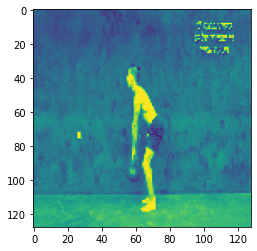

In [7]:
import matplotlib.pyplot as plt
for i in dataset:
  plt.imshow(i[0][0].numpy())
  break


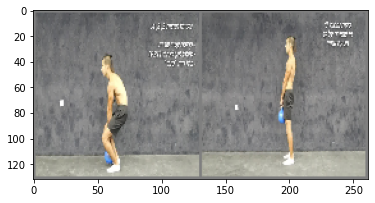

incorrect correct


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = {
    0: 'incorrect',
    1: 'correct',
}

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(13456, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


net = Net().to(device)


# Train

In [21]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 2

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = torch.flatten(outputs)
        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,    20] loss: 0.007
[1,    40] loss: 0.007
[1,    60] loss: 0.006
[1,    80] loss: 0.005
[1,   100] loss: 0.005
[1,   120] loss: 0.005
[1,   140] loss: 0.005
[1,   160] loss: 0.005
[1,   180] loss: 0.006
[1,   200] loss: 0.005
[1,   220] loss: 0.004
[1,   240] loss: 0.005
[1,   260] loss: 0.005
[2,    20] loss: 0.005
[2,    40] loss: 0.005
[2,    60] loss: 0.004
[2,    80] loss: 0.004
[2,   100] loss: 0.006
[2,   120] loss: 0.006
[2,   140] loss: 0.004
[2,   160] loss: 0.003
[2,   180] loss: 0.006
[2,   200] loss: 0.004
[2,   220] loss: 0.003
[2,   240] loss: 0.003
[2,   260] loss: 0.003
Finished Training


# Test

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 42 %


In [26]:
n_neg = len(os.listdir('/content/FitnessAI/CNN - Accuracy/deadlift/negative'))
n_pos = len(os.listdir('/content/FitnessAI/CNN - Accuracy/deadlift/positive'))
n_neg/(n_neg+n_pos), n_pos/(n_neg+n_pos)

NameError: ignored